# Cross-Assay Integrative Analyses

In [46]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from venn import venn
%matplotlib inline

## 1. Loading allele information

### 1.1 VarChAMP Dataset Alleles Merged with Pillar Project

In [47]:
varchamp_pillar_df = pl.read_csv("../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", 
                                 separator="\t", infer_schema_length=1000000)
print("VarChAMP dataset shape:", varchamp_pillar_df.shape)

VarChAMP dataset shape: (130649, 582)


In [48]:
varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("gene_variant")

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i64,f64,str,…,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str
"""MSH2""",null,7918,null,"""CCSBVarC010836""",null,"""NC_000002.12:47403329:C:G""",null,"""His46Gln""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_His46Gln""",2,4.7403329e7,"""C""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_His46Gln""","""His46Gln""",true,"""2:47403329:C:G"""
"""PTEN""","""ENSG00000171862""",100011574,210310,"""CCSBVarC007033""","""ALE00007031""","""NC_000010.11:87933145:G:A""","""386G>A""","""Gly129Glu""","""CEGS2""","""CegsMutGDEh1023""","""A08""","""GDEhDisVCh_40031""","""C08""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""PTEN_Gly129Glu""",10,8.7933145e7,"""G""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""PTEN_Gly129Glu""","""Gly129Glu""",true,"""10:87933145:G:A"""
"""OTC""","""ENSG00000036473""",71569,205886,"""CCSBVarC005240""","""ALE00005240""","""NC_000023.11:38401304:T:C""","""416T>C""","""Leu139Ser""","""CEGS2""","""CegsMutGDEh1016""","""F07""","""GDEhDisVCh_40048""","""B03""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""OTC_Leu139Ser""",23,3.8401304e7,"""T""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""OTC_Leu139Ser""","""Leu139Ser""",true,"""X:38401304:T:C"""
"""F9""","""ENSG00000101981""",52861,24496,"""CCSBVarC002180""","""ALE00002180""","""NC_000023.11:139537138:G:A""","""217G>A""","""Glu73Lys""","""RC4"

In [49]:
# pillar_clinvar_df = pl.read_csv(
#     "../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
#     schema_overrides={
#         "Chrom": pl.String, 
#         'aa_pos': pl.String, 
#         'auth_reported_score': pl.String
#     },
#     infer_schema_length=10000
# ).with_columns(
#     pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
#     pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
# ).with_columns(
#     pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
#     pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
#     pl.col("hg38_start").alias("nuc_loc"),
#     pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
#     pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
# ).with_columns(
#     pl.concat_str(
#         [
#             pl.col("Gene"),
#             pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
#         ],
#         separator="_"
#     ).alias("gene_variant")
# )
# print("Original pillar dataset shape:", pillar_clinvar_df.shape)

# ## filter the SNP variants only
# pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
#     (pl.col("consequence").str.contains("sense")) & \
#     (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
#     (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
# ).drop_nulls(subset="hgvs_p").with_columns(
#     pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
#     pl.lit(True).alias("pillar_tested")
# )
# print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

# pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
#     "gene_variant", "gnomad_MAF", descending=[False,False]
# )
# print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
# print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

### 1.2 Imaging Data

In [13]:
img_metric_df = pl.DataFrame()
img_metric_df = pl.read_csv("../1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
img_metric_df = img_metric_df.with_columns(
    pl.col("gene_allele").alias("gene_variant")
)
print("VarChAMP Imaging assay unique variants:", img_metric_df.unique(subset=["gene_variant"]).shape[0])
img_metric_df

VarChAMP Imaging assay unique variants: 475


Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,gene_variant,ensembl_gene_id,clinvar_clnsig_clean,gnomad_af,StarStatus
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,str,str,str,str,i64
"""CCM2""","""CCM2_Ser164Phe""",-3.381957,0.240365,-6.822482,0.023461,"""2025_01_Batch_13-14""",0.9846,0.890684,0.86573,0.920519,0.974059,0.771795,0.857046,0.796482,0.773114,0.71835,0.878198,0.873865,0.831106,0.846817,0.846204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""CCM2_Ser164Phe""",null,null,null,null
"""ZC4H2""","""ZC4H2_Val63Leu""",3.772509,0.00952,3.575493,1.0,"""2025_01_Batch_13-14""",0.606618,0.837648,0.878378,0.809909,0.702406,0.608014,0.932117,0.963377,0.944315,0.673811,0.607316,0.884883,0.920877,0.877112,0.688108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,4320,215106,"""ZC4H2""","""Val63Leu""","""ZC4H2_Val63Leu""","""ENSG00000126970""","""1_Pathogenic""",null,null
"""CCM2""","""CCM2_Asp442Asn""",-0.383562,1.0,-22.40718,0.000046,"""2025_01_Batch_13-14""",0.834116,0.880765,0.882302,0.890109,0.728985,0.811802,0.937672,0.944296,0.880764,0.774808,0.822959,0.909218,0.913299,0.885436,0.751896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""CCM2_Asp442Asn""",null,null,null,null
"""SDHD""","""SDHD_Glu69Lys""",-7.23288,0.000174,1.091807,1.0,"""2025_01_Batch_13-14""",0.882103,0.889458,0.869516,0.889995,0.840951,0.878528,0.868099,0.855617,0.875983,0.823156,0.880316,0.878778,0.862567,0.882989,0.832053,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""SDHD_Glu69Lys""",null,null,null,null
"""CCM2""","""CCM2_Cys170Tyr""",-4.804395,1.0,-9.165346,0.152883,"""2025_01_Batch_13-14""",0.83229,0.766426,0.806224,0.830215,0.685391,0.635488,0.732029,0.776341,0.68173,0.573847,0.733889,0.749227,0.791282,0.755972,0.629619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""CCM2_Cys170Tyr""",null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""F9""","""F9_Phe395Ile""",2.751249,0.028453,-3.180985,0.015469,"""2025_01_Batch_13-14""",0.781915,0.712288,0.820742,0.819575,0.611101,0.5173,0.806238,0.929957,0.886326,0.706212,0.649607,0.759263,0.875349,0.85295,0.658657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""F9_Phe395Ile""",null,null,null,null
"""F9""","""F9_Ala397Pro""",2.551531,0.038019,-1.811503,0.112966,"""2025_01_Batch_13-14""",0.554545,0.744487,0.836446,0.837184,0.525068,0.523175,0.845475,0.938083,0.888878,0.690149,0.53886,0.794981,0.887265,0.863031,0.607608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,52861,204368,"""F9""","""Ala397Pro""","""F9_Ala397Pro""","""ENSG00000101981""","""1_Pathogenic""",null,null
"""F9""","""F9_Cys124Tyr""",null,null,-7.778249,0.000109,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,null,null,null,null,"""F9_Cys124Tyr""",null,null,null,null


### 1.3 DUAL-IPA and PPI alleles

symbol,node_type,nt_change,aa_change,pla,well,coordinates,n_cells,orf_id,mut_id,valid_well,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,…,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp,dualipa_abund_change,dualipa_assayed
str,str,str,str,i64,str,str,i64,i64,i64,bool,f64,f64,f64,f64,f64,f64,i64,f64,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str,bool,bool
"""KCNJ2""","""allele""","""821A>T""","""Asp274Val""",11,"""H06""","""11_H06""",4976,100016069,2638,true,897.920013,2918.650024,0.253414,0.841771,0.301048,-1.871967,-1,-3.706326,"""ENSG00000123700""",100016069,2638,"""CCSBVarC008340""","""ALE00008326""","""NC_000017.11:70175860:A:T""","""Edgotyping3""","""VUSMutGDEh010""","""D06""","""GDEhDisVCh_40005""","""C10""","""1""","""VUSMutGDDh010""","""D06""","""VUSN2Hmut_GDN2h_03""","""F09""","""VUSMutpDEST2_16""","""D04""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true
"""PKP2""","""allele""","""1415A>G""","""Lys472Arg""",19,"""F05""","""19_F05""",2900,54308,3072,true,718.52002,912.559998,0.674567,0.629182,1.072134,0.089182,0,0.271021,"""ENSG00000057294""",54308,3072,"""CCSBVarC008023""","""ALE00008009""","""NC_000012.12:32841169:T:C""","""Edgotyping3""","""VUSMutGDEh015""","""H02""","""GDEhDisVCh_40015""","""E08""","""1""","""VUSMutGDDh015""","""H02""","""VUSN2Hmut_GDN2h_04""","""E05""","""VUSMutpDEST2_12""","""G08""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,true
"""KCNJ2""","""allele""","""899G>A""","""Gly300Asp""",11,"""D07""","""11_D07""",8822,100016069,2641,true,693.679993,5069.049805,0.133067,0.841771,0.15808,-2.235586,-2,-5.723496,"""ENSG00000123700""",100016069,2641,"""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""","""1""","""VUSMutGDDh010""","""G06""","""VUSN2Hmut_GDN2h_03""","""H09""","""VUSMutpDEST2_16""","""G04""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true
"""HBD""","""allele""","""174C>A""","""Asn58Lys""",26,"""E05""","""26_E05""",9609,13796,218146,true,33.84,2474.280029,0.012192,0.077713,0.156882,-2.238633,-2,-5.747315,

VarChAMP DUAL-IPA assay unique variants: 919


gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,ppi_assayed,symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,…,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp,orf_id,mut_id
str,i64,i64,i64,i64,f64,f64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str,f64,f64
"""CTCF_Arg342Cys""",1,0,0,0,0.0,0.0,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010851""",null,"""NC_000016.10:67616816:C:T""",null,"""Arg342Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Arg342Cys""","""Arg342Cys""",true,"""16:67616816:C:T""",6173.0,null
"""CTCF_His455Gln""",2,0,0,0,0.0,0.0,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010858""",null,"""NC_000016.10:67626562:C:G""",null,"""His455Gln""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_His455Gln""","""His455Gln""",true,"""16:67626562:C:G""",6173.0,null
"""CTCF_Tyr407Cys""",2,0,0,0,0.0,0.0,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010870""",null,"""NC_000016.10:67621454:A:G""",null,"""Tyr407Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Tyr407Cys""","""Tyr407Cys""",true,"""16:67621454:A:G""",6173.0,null
"""GCK_Ala387Glu""",2,1,0,1,50.0,0.0,50.0,true,"""GCK""","""ENSG00000106633""",3689,214861,"""CCSBVarC006699""","""ALE00006697""","""NC_000007.14:44145590:G:T""","""1160C>A""","""Ala387Glu""","""CEGS2""","""CegsMutGDEh1043""","""B11""","""GDEhDisVCh_40037""","""F01""","""1""","""CegsMutGDDh1043""","""B11""","""VUSN2Hmut_GDN2h_09""","""H03""","""VUSMutpDEST2_03""","""B10""","""VUSmut_GDEh09""","""H03""",1,"""1""",1,"""1""",1,…,null,null,null,null,null,null,null,null,null,null,null,null,36181.0,"""CA213725""","""monogenic diabetes""","""MONDO:0015967""","""Semidominant inheritance""","""Likely Pathog

VarChAMP DUAL-IPA assay unique variants: 586
VarChAMP DUAL-IPA and PPI assay unique variants: 1186


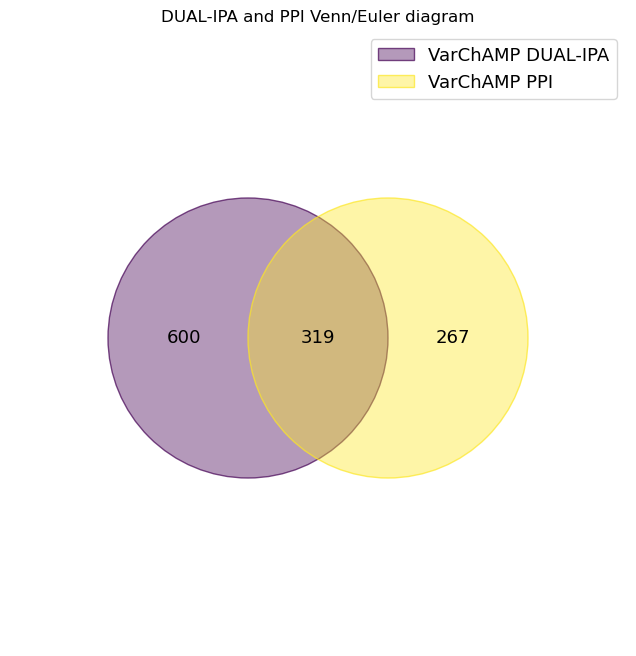

In [50]:
dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv", infer_schema_length=1000000)
display(dual_ipa_df)
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["gene_variant"]).shape[0])
ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv", infer_schema_length=1000000)
display(ppi_sum_df)
print("VarChAMP DUAL-IPA assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

# ppi_df = pl.read_csv("../1_inputs/ppi/edgotyping_final_combined_scores.csv").with_columns(
#     pl.lit(True).alias("VarChAMP_PPI")
# )
# ppi_df = ppi_df.join(
#     ppi_sum_df,
#     on="gene_variant"
# )

dual_ppi_df = dual_ipa_df.join(
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)
print("VarChAMP DUAL-IPA and PPI assay unique variants:", dual_ppi_df.unique(subset=["gene_variant"]).shape[0])

# Create the diagrams with your data
dual_ppi_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}

venn(dual_ppi_set)
plt.title("DUAL-IPA and PPI Venn/Euler diagram")
plt.show()

In [58]:
dual_ipa_df.filter(dual_ipa_df.select(pl.col("gene_variant")).is_duplicated()).sort("gene_variant")

symbol,node_type,nt_change,aa_change,pla,well,coordinates,n_cells,orf_id,mut_id,valid_well,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,…,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp,dualipa_abund_change,dualipa_assayed
str,str,str,str,i64,str,str,i64,i64,i64,bool,f64,f64,f64,f64,f64,f64,i64,f64,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str,bool,bool
"""ACSF3""","""allele""","""1411C>T""","""Arg471Trp""",10,"""H09""","""10_H09""",9630,71337,205772,true,625.600037,2927.749878,0.203886,0.273766,0.744747,-0.74348,0,-0.869953,"""ENSG00000176715""",71337,205772,"""CCSBVarC003581""","""ALE00003581""","""NC_000016.10:89145311:C:T""","""CEGS2""","""CegsMutGDEh1038""","""D01""","""NULL""","""NULL""","""NULL""","""CegsMutGDDh1038""","""D01""","""VUSN2Hmut_GDN2h_07""","""B10""","""VUSMutpDEST2_15""","""F06""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,true
"""ACSF3""","""allele""","""1411C>T""","""Arg471Trp""",10,"""D09""","""10_D09""",9442,71337,3960,false,697.359985,3317.300049,0.213948,0.273766,0.7815,-0.650005,0,-0.719111,"""ENSG00000176715""",71337,3960,"""CCSBVarC003581""","""ALE00003581""","""NC_000016.10:89145311:C:T""","""Edgotyping3""","""VUSMutGDEh009""","""A08""","""GDEhDisVCh_40021""","""F12""","""1""","""VUSMutGDDh009""","""A08""","""VUSN2Hmut_GDN2h_03""","""E03""","""VUSMutpDEST2_15""","""B06""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,true
"""ACSF3""","""allele""","""1075G>A""","""Glu359Lys""",10,"""F09""","""10_F09""",11224,71337,205770,true,537.280029,1841.699951,0.265714,0.273766,0.97059,-0.169081,0,-0.040564,"""ENSG00000176715""",71337,205770,"""CCSBVarC003580""","""ALE00003580""","""NC_000016.10:89114436:G:A""","""CEGS2""","""CegsMutGDEh1037""","""C09""","""NULL""","""NULL""","""NULL""","""CegsMutGDDh1037""","""C09""","""VUSN2Hmut_GDN2h_07""","""A09""","""VUSMutpDEST2_15""","""D06""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,true
"""ACSF3""","""allele""","""1075G>A""","""Glu359Lys""",10,"""A09""","""10_A09""",10856,71337,3952,true,403.880005,2710.399902,0.151772,0.273766,0.554387,-1.227636,-1,-1.794297,"""ENSG0000017

<Axes: xlabel='zscore_log2', ylabel='perturbed_percentage'>

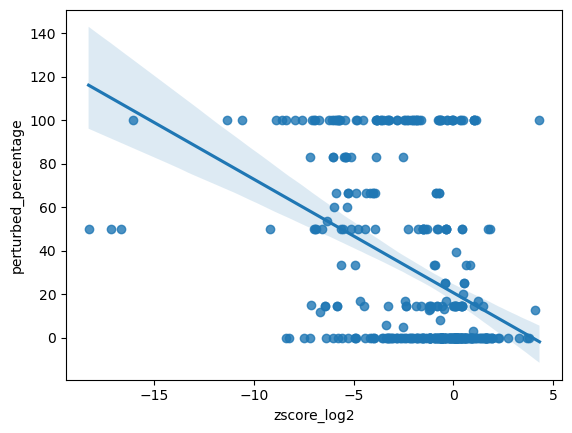

In [17]:
sns.regplot(data=dual_ppi_df.to_pandas(),
            x="zscore_log2",
            y="perturbed_percentage")

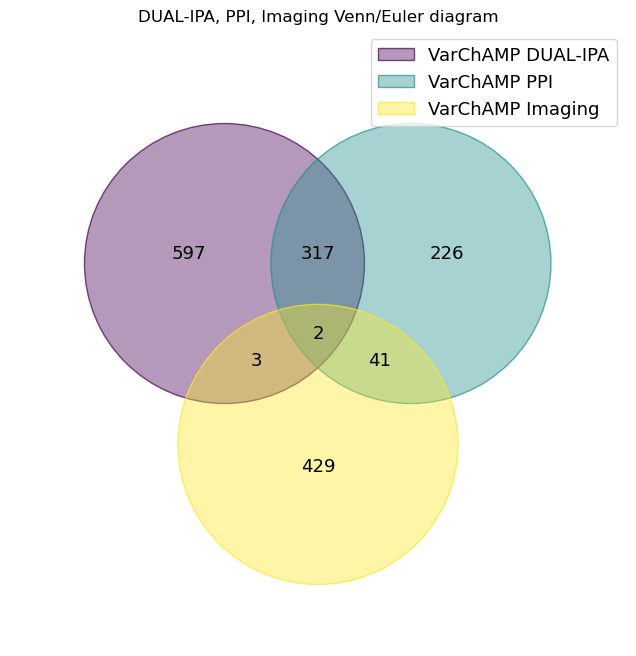

In [18]:
# Create the diagrams with your data
dual_ppi_img_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique())
}

venn(dual_ppi_img_set)
plt.title("DUAL-IPA, PPI, Imaging Venn/Euler diagram")
plt.show()

In [19]:
print("VarChAMP PPI assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

img_dual_ppi_df = img_metric_df.join( ## .unique(subset=["gene_variant"])
    dual_ipa_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_dualipa"
).join( ## .unique(subset=["gene_variant"])
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)
img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
)
img_dual_ppi_df

VarChAMP PPI assay unique variants: 586


Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,…,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi,spdi_trimmed_pp_ppi,orf_id_ppi,mut_id_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str,f64,f64
"""KCNJ2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""PKP2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""KCNJ2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.00016069e8,2641.0
"""HBD""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,13796.0,218146.0
"""SMAD3""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,

In [23]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))&(pl.col("dualipa_assayed")))

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,…,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi,spdi_trimmed_pp_ppi,orf_id_ppi,mut_id_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str,f64,f64
"""GSS""","""GSS_Arg125Cys""",null,null,null,null,"""2025_01_Batch_13-14""",0.602072,0.653072,0.763212,0.7237,0.566457,0.539237,0.619455,0.548967,0.649187,0.499309,0.570654,0.636264,0.656089,0.686444,0.532883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,5132,215352,"""GSS""","""Arg125Cys""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5132.0,215352.0
"""BCL10""","""BCL10_Leu8Leu""",1.593538,0.186262,-1.852878,0.106317,"""2025_01_Batch_13-14""",0.535754,0.635298,0.663309,0.691869,0.493863,0.882353,0.759233,0.764702,0.821239,0.579186,0.709053,0.697265,0.714005,0.756554,0.536524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,11832,20121,"""BCL10""","""Leu8Leu""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,11832.0,20121.0
"""BCL10""","""BCL10_Leu8Leu""",1.593538,0.186262,-1.852878,0.106317,"""2025_01_Batch_13-14""",0.535754,0.635298,0.663309,0.691869,0.493863,0.882353,0.759233,0.764702,0.821239,0.579186,0.709053,0.697265,0.714005,0.756554,0.536524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,11832,20121,"""BCL10""","""Leu8Leu""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,11832.0,null


In [38]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).group_by("Gene").agg(
    pl.col("Gene").len().alias("Count")
)

Gene,Count
str,u32
"""RAD51D""",14
"""BCL10""",2
"""SDHD""",17
"""CTCF""",4
"""FARS2""",9
"""GSS""",1


<Axes: xlabel='AUROC_Mean_Morph', ylabel='perturbed_percentage'>

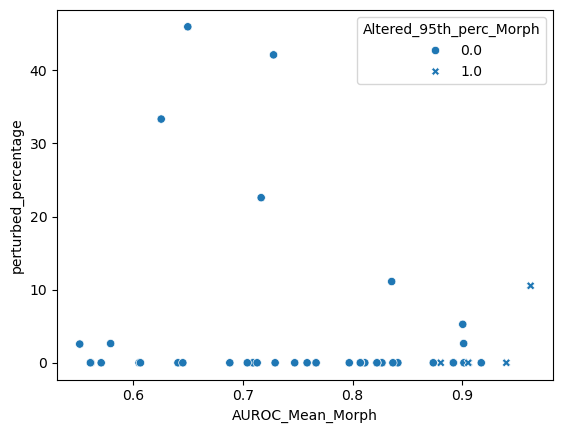

In [34]:
sns.scatterplot(data=img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).to_pandas(),
                x="AUROC_Mean_Morph",
                y="perturbed_percentage",
                style="Altered_95th_perc_Morph")

In [43]:
# g = sns.catplot(data=pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]).unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
#                 x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

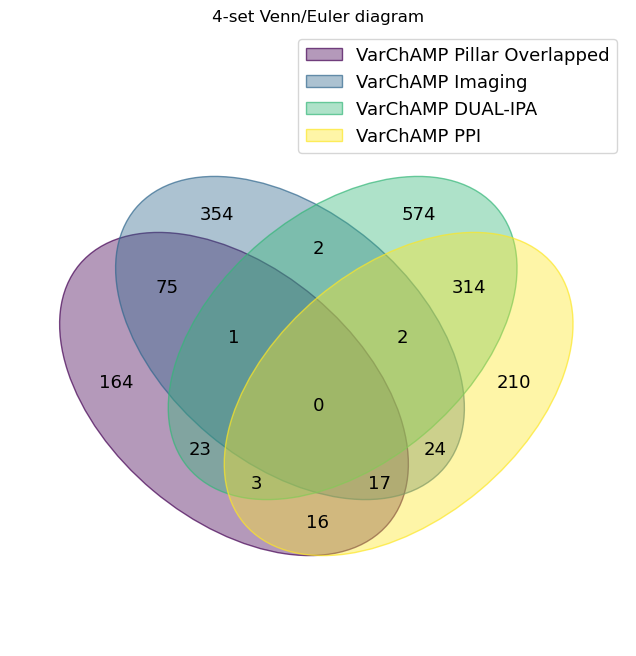

In [45]:
# Create the diagrams with your data
sets_data = {
    'VarChAMP Pillar Overlapped': set(varchamp_pillar_df.filter(pl.col("pillar_tested"))["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}

venn(sets_data)
plt.title("4‐set Venn/Euler diagram")
plt.show()

## 2. Functional Assay Mapping

In [40]:
def plot_gene_level_summary(df, hit_col, cell_change, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort("len", descending=False)
    ).to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.4
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.legend(fontsize=11, loc="lower right")

In [ ]:
pillar_assayed = varchamp_pillar_df.

### 2.1 Imaging

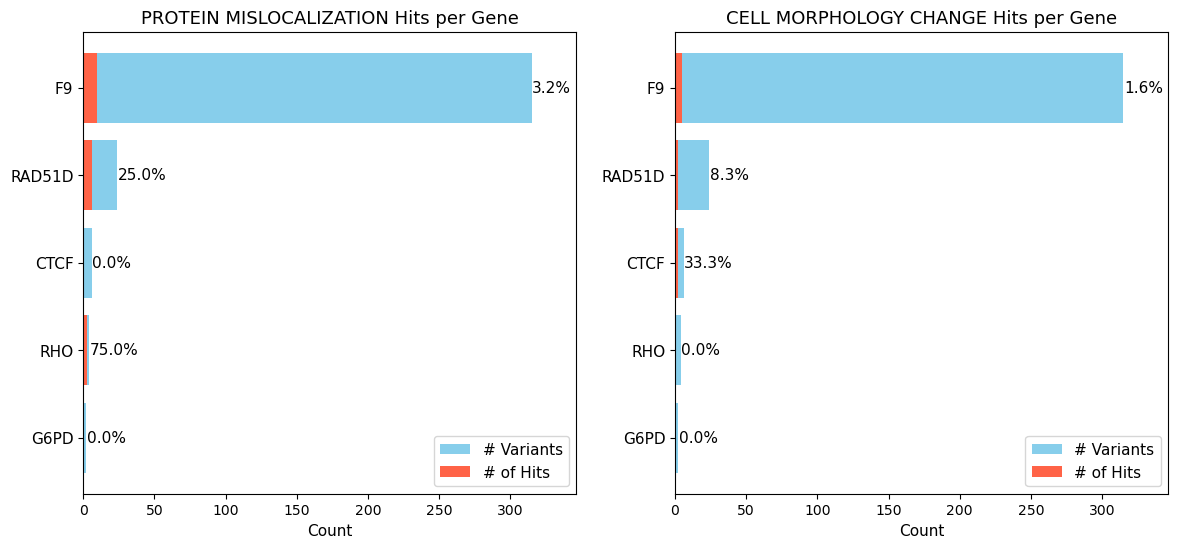

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
plot_gene_level_summary(pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]), "Altered_GFP_95_both_batches", "Protein Mislocalization", ax=ax[0])
plot_gene_level_summary(pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]), "Altered_Morph_95_both_batches", "Cell Morphology Change", ax=ax[1])
plt.subplots_adjust(wspace=0.2)

In [45]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True
        )

### 2.2 DUAL-IPA assay

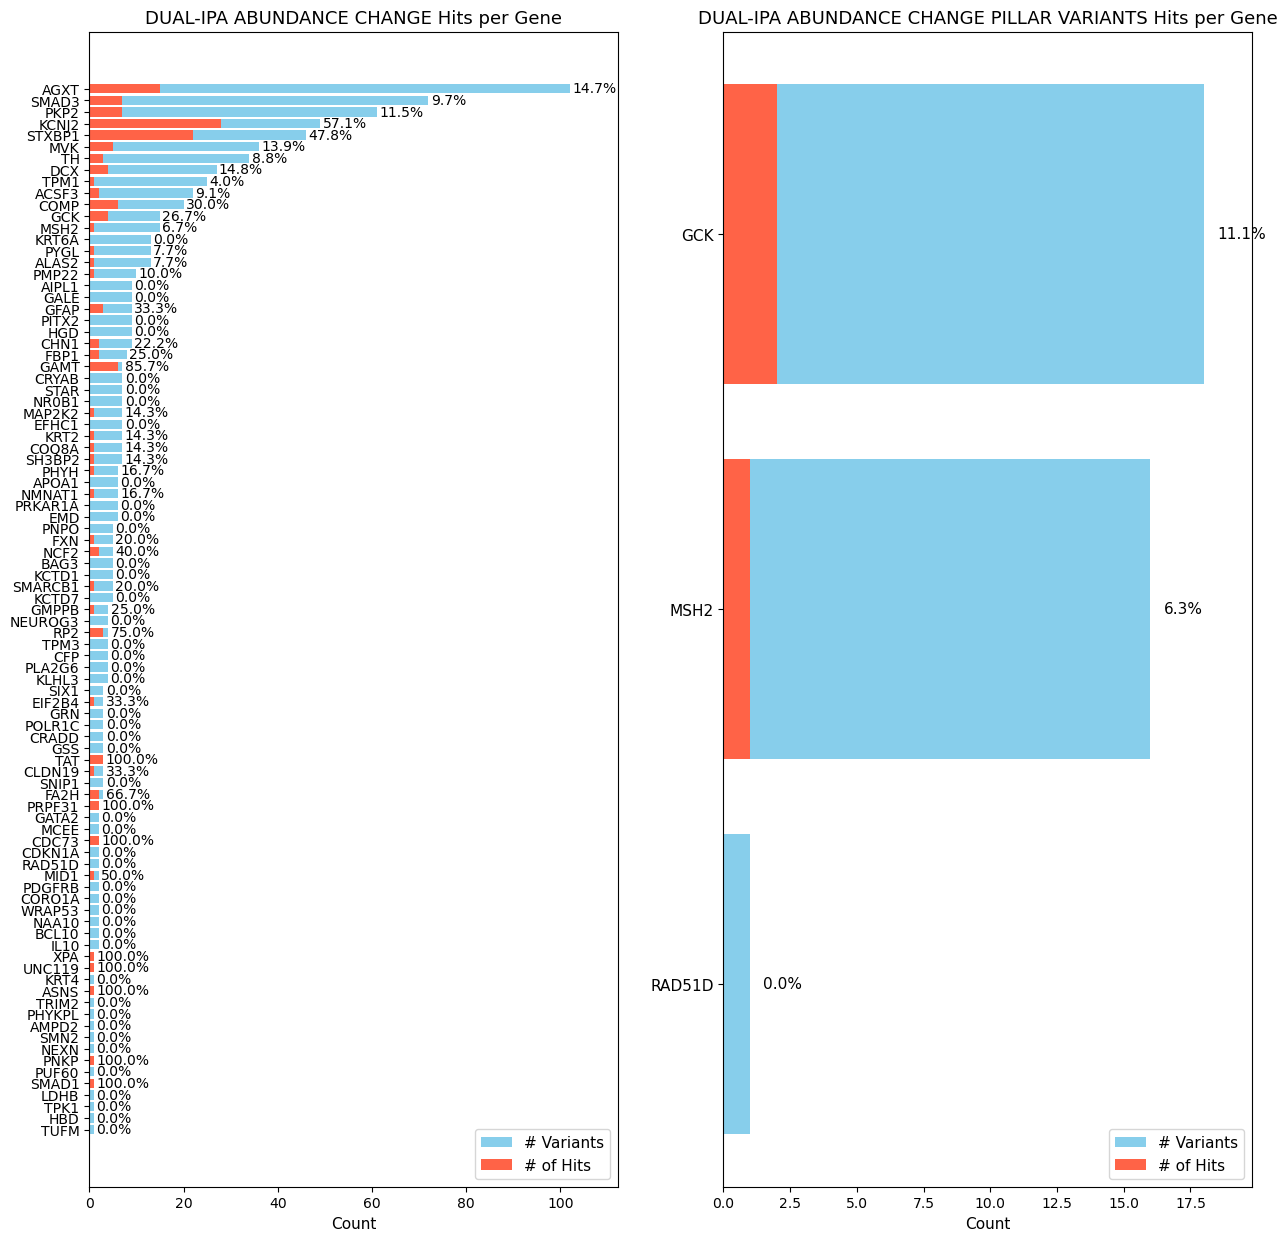

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
plot_gene_level_summary(dual_ipa_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change", ax=ax[0])
plot_gene_level_summary(pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change Pillar Variants", ax=ax[1])

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""MSH2_Lys627Asn""",null,"""Loss of function""","""Abnormal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Low abundance ""","""Abnormal"""
"""MSH2_Gly40Ser""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""GCK_Ala456Val""","""Pathogenic""","""Decreased activity""","""Abnormal"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""MSH2_Ala714Val""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""MSH2_Leu92Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""WT-like""","""Normal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Pro622Leu""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Thr335Ile""","""Uncertain significance""","""WT-like""","""Normal"""
"""MSH2_Glu562Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Ala305Thr""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""GCK_Ala456Val""","""Pathogenic""","""Hyperactive""","""Not specified"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""WT-like""","""Normal"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala456Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Met251Thr""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala378Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Synonymous""","""Abnormal"""
"""GCK_Met381Arg""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


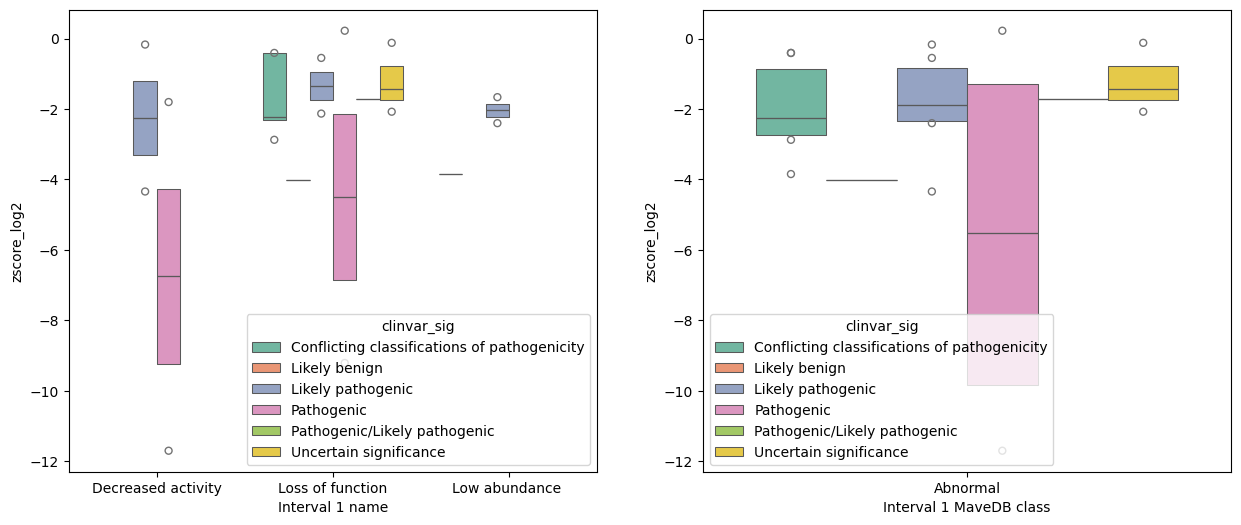

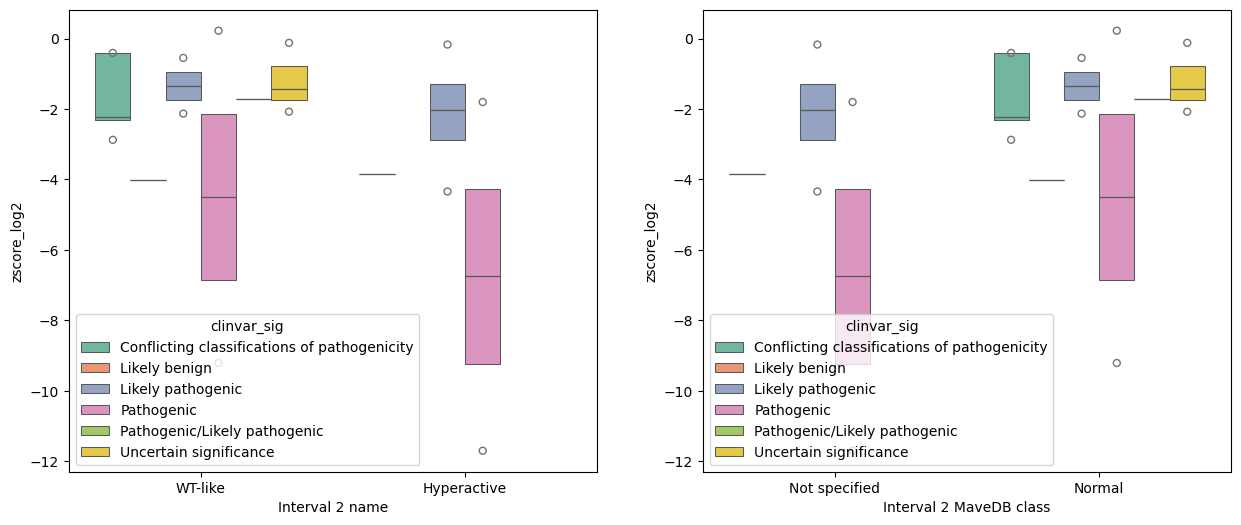

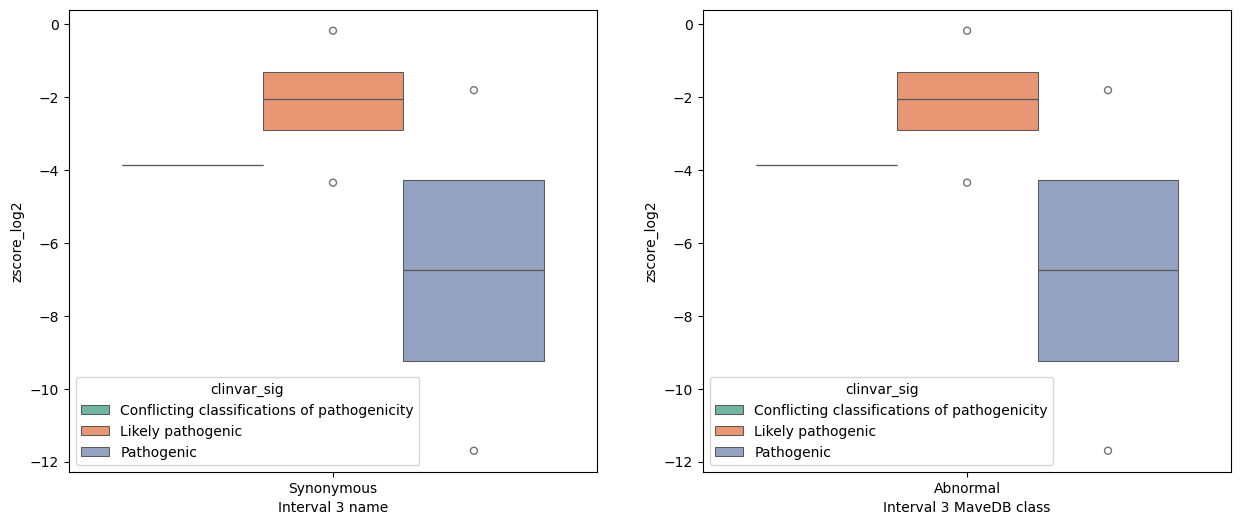

In [51]:
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_scores.drop_nulls("clinvar_sig").unique("clinvar_sig")["clinvar_sig"])
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )

### 2.3 PPI assays

In [56]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_PPI",int_name, mavedb_name])
    # print(func_scores)
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores["gene_variant","clinvar_sig",int_name, mavedb_name])
    # if func_scores.shape[0] > 0:
    #     fig, ax = plt.subplots(1,2,figsize=(12,6))
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=int_name,
    #         y="perturbed_percentage",
    #         ax=ax[0]
    #     )
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=mavedb_name,
    #         y="perturbed_percentage",
    #         ax=ax[1]
    #     )

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


In [57]:
ppi_df.filter(pl.col("gene_variant")=="GCK_Ala387Glu")

ad_orf_id,nt_change,final_score_wt,symbol,db_orf_id,edgotype,aa_change,final_score,ad_symbol,edgotype_wt_2,gene_variant,edgotype_wt_final,VarChAMP_PPI,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage
i64,str,i64,str,i64,str,str,i64,str,str,str,str,bool,i64,i64,i64,i64,f64,f64,f64
54784,"""1160C>A""",3,"""GCK""",3689,"""not perturbed""","""Ala387Glu""",3,"""GCKR""","""not perturbed""","""GCK_Ala387Glu""","""not perturbed""",true,2,1,0,1,50.0,0.0,50.0
70835,"""1160C>A""",4,"""GCK""",3689,"""perturbed""","""Ala387Glu""",0,"""SPDYE4""","""perturbed""","""GCK_Ala387Glu""","""perturbed""",true,2,1,0,1,50.0,0.0,50.0
